<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/Fundus-eye-disease-detection/Res_Mob_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#  MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
#  DEFINE DATASET PATHS
DATA_DIR = '/content/drive/MyDrive/data set/dataset'
FEATURE_DIR = '/content/drive/MyDrive/extracted_feature'

#  FUNCTION TO GET IMAGE DIRECTORIES
def get_class_directories(base_directory):
    return {folder_name: os.path.join(base_directory, folder_name) for folder_name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, folder_name))}


image_directories = get_class_directories(DATA_DIR) # capture the return value here
class_names = list(image_directories.keys())
print(f"Classes found: {class_names}")

Classes found: ['diabetic_retinopathy', 'glaucoma', 'cataract', 'normal']


In [4]:
#  SPLIT DATASET INTO TRAIN & TEST (Removed incorrect stratification)
train_dirs, test_dirs = {}, {}
for category, dir_path in image_directories.items():
    img_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
    train_files, test_files = train_test_split(img_files, test_size=0.2, random_state=42)
    train_dirs[category] = train_files
    test_dirs[category] = test_files

📂 First 5 Images from Each Category (Train & Test):

🔸 Category: diabetic_retinopathy
🔸 Category: glaucoma
🔸 Category: cataract
🔸 Category: normal


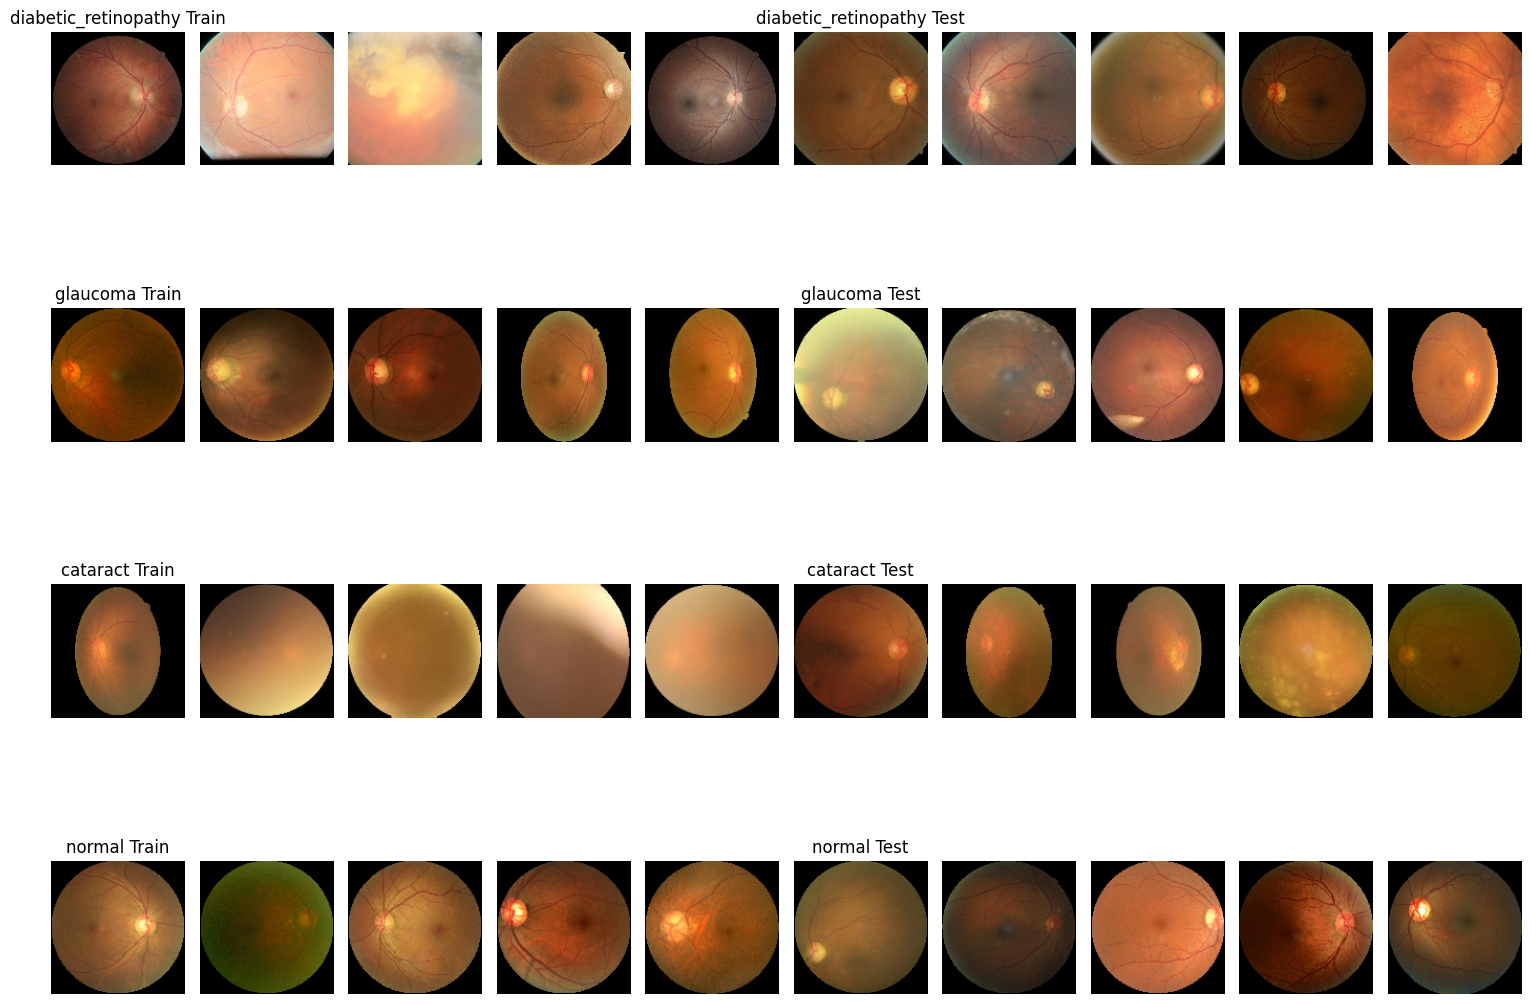

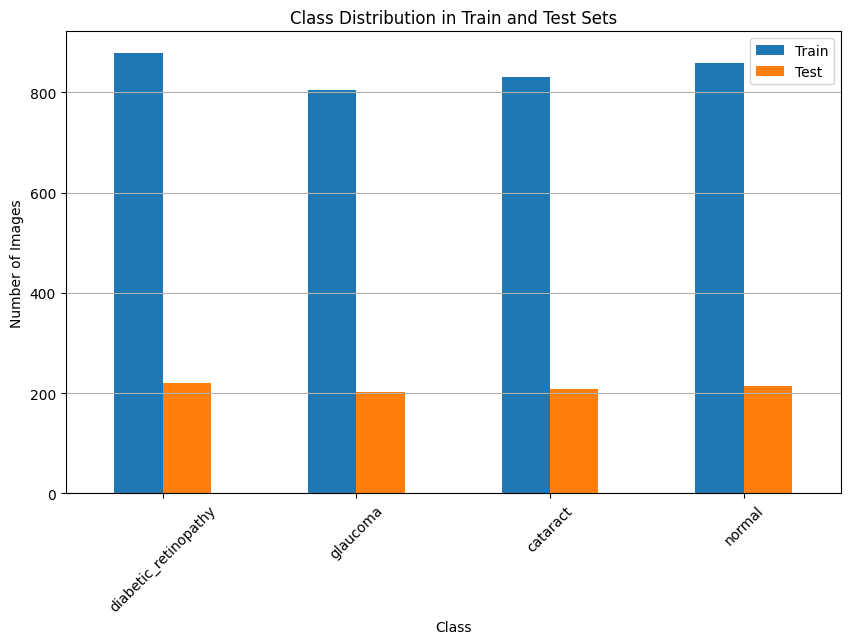

In [5]:
import pandas as pd
# Display first 5 images from each category
def display_first_five_images(train_dirs, test_dirs):
    print("📂 First 5 Images from Each Category (Train & Test):\n")

    num_categories = len(train_dirs)
    fig, axes = plt.subplots(num_categories, 10, figsize=(15, num_categories * 3))

    for i, category in enumerate(train_dirs.keys()):
        print(f"🔸 Category: {category}")

        for j, img_path in enumerate(train_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{category} Train', fontsize=12)

        for j, img_path in enumerate(test_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j + 5].imshow(img)
            axes[i, j + 5].axis('off')
            if j == 0:
                axes[i, j + 5].set_title(f'{category} Test', fontsize=12)

    plt.tight_layout()
    plt.show()

display_first_five_images(train_dirs, test_dirs)

# Plot class distribution
def plot_class_distribution(train_dirs, test_dirs, class_names):
    train_counts = {category: len(files) for category, files in train_dirs.items()}
    test_counts = {category: len(files) for category, files in test_dirs.items()}

    df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts})
    df_counts.plot(kind='bar', figsize=(10, 6))
    plt.title('Class Distribution in Train and Test Sets')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_class_distribution(train_dirs, test_dirs, class_names)


In [6]:
#  LOAD  ResNet50 & MobileNetV3Large

!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras.applications import resnet50, mobilenet_v3

def load_model(model_name):
    if model_name == "ResNet50":
        model = resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')
        preprocessor = resnet50.preprocess_input
    elif model_name == "MobileNetV3Large":
        model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        preprocessor = tf.keras.applications.mobilenet_v3.preprocess_input
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    return model, preprocessor

models, preprocessors = [], []
for model_name in ["ResNet50", "MobileNetV3Large"]:
    model, preprocessor = load_model(model_name)
    models.append(model)
    preprocessors.append(preprocessor)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
#  FUNCTION TO EXTRACT FEATURES
def preprocess_and_extract_features(img_path, model, preprocess_input, img_size=(224, 224)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array, verbose=0)
    return features.flatten()

#  FUNCTION TO EXTRACT & SAVE FEATURES (Updated filename consistency)
def extract_and_save_features(image_files, models, preprocessors, output_dir, category):
    features_list = []
    for img in image_files:
        extracted_features = [preprocess_and_extract_features(img, model, preprocessor) for model, preprocessor in zip(models, preprocessors)]
        features_list.append(np.concatenate(extracted_features, axis=0))
    os.makedirs(output_dir, exist_ok=True)
    np.save(f'{output_dir}/{category}_features.npy', np.array(features_list))

#  EXTRACT & SAVE FEATURES
for split_name, dirs in zip(['train', 'test'], [train_dirs, test_dirs]):
    for category, image_files in dirs.items():
        output_dir = f'{FEATURE_DIR}/ResNet50_MobileNetV3Large/{split_name}/{category}'
        extract_and_save_features(image_files, models, preprocessors, output_dir, category)

In [8]:
#  LOAD EXTRACTED FEATURES (Updated filename loading)
X_train, y_train, X_test, y_test = [], [], [], []
for category in class_names:
    train_features = np.load(f'{FEATURE_DIR}/ResNet50_MobileNetV3Large/train/{category}/{category}_features.npy')
    test_features = np.load(f'{FEATURE_DIR}/ResNet50_MobileNetV3Large/test/{category}/{category}_features.npy')
    X_train.append(train_features)
    y_train.append(np.full(train_features.shape[0], class_names.index(category)))
    X_test.append(test_features)
    y_test.append(np.full(test_features.shape[0], class_names.index(category)))

X_train, y_train = np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)
X_test, y_test = np.concatenate(X_test, axis=0), np.concatenate(y_test, axis=0)

In [9]:
#  COMPUTE CLASS WEIGHTS
def get_class_weight_dict(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return dict(zip(np.unique(y_train), class_weights))


In [10]:
#  TRAIN MULTIPLE SGD CLASSIFIERS WITH DIFFERENT LOSS FUNCTIONS (Adjusted hyperparameters)
loss_functions = ["log_loss", "hinge", "modified_huber", "squared_hinge", "perceptron"]
class_weight_dict = get_class_weight_dict(y_train)

classifiers = []
for loss_function in loss_functions:
    print(f"\nTraining with loss function: {loss_function}")
    clf = SGDClassifier(loss=loss_function, class_weight=class_weight_dict, max_iter=1000, tol=1e-4, learning_rate='adaptive', eta0=0.01, random_state=42)
    clf.fit(X_train, y_train)
    classifiers.append((loss_function, clf))

# CREATE VOTING CLASSIFIER
voting_clf = VotingClassifier(estimators=classifiers, voting="hard")
voting_clf.fit(X_train, y_train)



Training with loss function: log_loss

Training with loss function: hinge

Training with loss function: modified_huber

Training with loss function: squared_hinge

Training with loss function: perceptron


VotingClassifier(estimators=[('log_loss',
                              SGDClassifier(class_weight={0: 0.9601366742596811,
                                                          1: 1.0472049689440994,
                                                          2: 1.0156626506024096,
                                                          3: 0.9813736903376019},
                                            eta0=0.01, learning_rate='adaptive',
                                            loss='log_loss', random_state=42,
                                            tol=0.0001)),
                             ('hinge',
                              SGDClassifier(class_weight={0: 0.9601366742596811,
                                                          1: 1.0472049689440994,
                                                          2: 1.0156626506024096,
                                                          3: 0.981373690337...
                                                          1: 1.0472049689440994,
                                                          2: 1.0156626506024096,
                                                          3: 0.9813736903376019},
                                            eta0=0.01, learning_rate='adaptive',
                                            loss='squared_hinge',
                                            random_state=42, tol=0.0001)),
                             ('perceptron',
                              SGDClassifier(class_weight={0: 0.9601366742596811,
                                                          1: 1.0472049689440994,
                                                          2: 1.0156626506024096,
                                                          3: 0.9813736903376019},
                                            eta0=0.01, learning_rate='adaptive',
                                            loss='perceptron', random_state=42,
                                            tol=0.0001))])